# Fake News Detection with DistilBERT

Group 01
- Alonso Geesink Anton ()
- Claudio Vincenzo Catalano Leiva (claudio.catalano.leiva@alumnos.upm.es)
- Seyit Ahmet Inci ()

Deep Learning Course 2025/26 - Course Project: Exercise 2 - Fine-tuning the Model with Experimentation

**Dataset**: [Fake News Detection Datasets](https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets/data)

**Code References using DistilBERT**:
- https://www.kaggle.com/code/henryukwuoma/fake-and-real-news-distilbert
- https://www.kaggle.com/code/shehabmagdy710/distilbert-fine-tuning-on-fake-news-data

## 1. Setup and Imports

The cell below contains package installations that you should do whenever you first use this Jupyter notebook. Additionally, remember to download the dataset files (true.csv & fake.csv) and place them on a new folder named **data**.

In [1]:
# Install required packages if needed
#!pip install transformers datasets  pandas numpy scikit-learn matplotlib seaborn tqdm accelerate
#!pip install torch --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/6.1 MB ? eta -:--:--
     ---------------------------------------- 6.1/6.1 MB 62.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
     ---------------------------------------- 4.1/4.1 MB 49.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 68.4 MB/s eta 0:00:36
     ---------------------------------------- 0.0/2.4 GB 68.4 MB/s eta 0:00:36
      --------------------------------------- 0.0/2.4 GB 70.2 MB/s eta 0:00:35
      --------------------------------------- 0.1/2.4 GB 70.4 MB/s eta 0:00:34
     - -------------------------------------- 0.1/2.4 GB 71.0 MB/s eta 0:00:34
     - -------------------------------------- 0.1/2.4 GB 70.2 MB/s eta 0:00:34
     - -------------------------------------- 0.1/2.4 GB 70.3 MB/s eta 0:00:34
     - ----------


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1.1. Initial Setup and Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import warnings
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from tqdm.auto import tqdm
import json
import os
from pathlib import Path
from datetime import datetime
import time

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility for torch and numpy in our machines
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device configuration -> In our case since we have a transformer mode if you guys have a gpu to use it will be faster
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using the following device for our training: {device}')

Using the following device for our training: cuda


## 2. Loading the Data from the Kaggle Dataset

Note: Before running this for our training, remember to check that the data files are in your local folder! You can find them from the dataset from Kaggle and place the CSV files in a `data/` directory.
Expected files:
- `Fake.csv`: Contains fake news articles
- `True.csv`: Contains true news articles

In [2]:
# Load the dataset which is split into two files: Fake.csv and True.csv
fake_df = pd.read_csv('data/Fake.csv')
true_df = pd.read_csv('data/True.csv')

# Add labels: 0 for fake, 1 for true
fake_df['label'] = 0
true_df['label'] = 1

# Combine the datasets so that we just have one file
df = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle the dataset to ensure random distribution for our training
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Basic info about the dataset
print(f"Total samples: {len(df)}")
print(f"Fake news: {len(fake_df)} ({len(fake_df)/len(df)*100:.2f}%)")
print(f"True news: {len(true_df)} ({len(true_df)/len(df)*100:.2f}%)")
print("\nDataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# Display first few rows
print("\nFirst few rows of the dataset: ")
df.head()

Total samples: 44898
Fake news: 23481 (52.30%)
True news: 21417 (47.70%)

Dataset shape: (44898, 5)

Columns: ['title', 'text', 'subject', 'date', 'label']

First few rows of the dataset: 


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


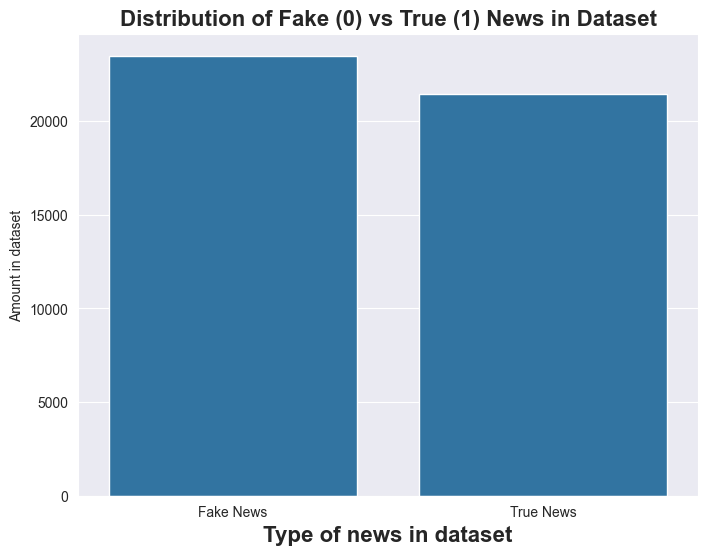

In [3]:
# Visualization of the dataset with label distribution using a count plot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Distribution of Fake (0) vs True (1) News in Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Type of news in dataset', fontsize=16, fontweight='bold')
plt.ylabel('Amount in dataset')
plt.xticks([0, 1], ['Fake News', 'True News'])
plt.show()

## 3. Data Preprocessing

In this section, we will preprocess the data to prepare it for training. This includes combining relevant text fields and splitting the dataset into training, validation, and test sets that will be used later for model training and evaluation.

In [4]:
# 1. Combine title and text into a single 'content' column
if 'title' in df.columns and 'text' in df.columns:
    df['content'] = df['title'] + ' ' + df['text']
elif 'text' in df.columns:
    df['content'] = df['text']
elif 'title' in df.columns:
    df['content'] = df['title']
else:
    # Find the text column
    text_cols = [col for col in df.columns if col not in ['label', 'subject', 'date']]
    if text_cols:
        df['content'] = df[text_cols[0]]
    else:
        raise ValueError("Could not find text column in dataset")

# 2. Clean Reuters tags from the combined content
import re

def clean_reuters_tag(s):
    if not isinstance(s, str):
        return s
    # Remove patterns like "(Reuters) - " or " (Reuters) "
    s = re.sub(r'\(?\bReuters\b\)?\s*-\s*', '', s, flags=re.IGNORECASE)
    s = re.sub(r'\(?\bReuters\b\)?', '', s, flags=re.IGNORECASE)
    return s.strip()

df['content'] = df['content'].apply(clean_reuters_tag)

# 3. Inspect average length after cleaning
print(f"Average content length: {df['content'].str.len().mean():.0f} characters")

print("Data preprocessing completed. Sample data:")
df[['content', 'label']].head()

Average content length: 2542 characters
Data preprocessing completed. Sample data:


,content,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,0
1,Trump drops Steve Bannon from National Securit...,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,1
3,OOPS: Trump Just Accidentally Confirmed He Lea...,0
4,Donald Trump heads for Scotland to reopen a go...,1


In [5]:
# First split: 85% train+val, 15% test
train_val_df, test_df = train_test_split(
    df, test_size=0.15, random_state=SEED, stratify=df['label']
)

# Second split: 82.35% train, 17.65% val from the train+val set
train_df, val_df = train_test_split(
    train_val_df, test_size=0.1765, random_state=SEED, stratify=train_val_df['label']
)

print(f"Training set size (70%): {len(train_df)}")
print(f"Validation set size (15%): {len(val_df)}")
print(f"Test set size (15%): {len(test_df)}")

Training set size (70%): 31427
Validation set size (15%): 6736
Test set size (15%): 6735


## 3.5 - Defining the configurations

In order to fine-tune our DistilBERT model for fake news detection, we will experiment with different hyperparameter configurations. Below are the configurations we will use for training, each with a unique combination of the following 3 hyperparameters: epochs, learning rate, and weight decay.

**Combinations:**
- **Config 1:** epochs=1, learning_rate=4e-5, weight_decay=0.00
- **Config 2:** epochs=2, learning_rate=3e-5, weight_decay=0.01
- **Config 3:** epochs=2, learning_rate=3e-5, weight_decay=0.005
- **Config 4:** epochs=3, learning_rate=2e-5, weight_decay=0.01
- **Config 5:** epochs=3, learning_rate=2e-5, weight_decay=0.015
- **Config 6:** epochs=4, learning_rate=1.5e-5, weight_decay=0.02

In [6]:
# Global training constants -> batch size and output directory to save results
BATCH_SIZE = 32
MAX_LENGTH = 128
OUTPUT_DIR = Path("DL_Milestone2_experiments")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# List of configurations with the following hyperparameters: epochs, learning_rate, weight_decay
configs = [
    {"name": "1", "epochs": 1,  "per_device_train_batch_size": BATCH_SIZE, "learning_rate": 3e-5,  "weight_decay": 0.02},
    {"name": "2", "epochs": 1, "per_device_train_batch_size": BATCH_SIZE, "learning_rate": 1.5e-5,  "weight_decay": 0.02},
    {"name": "3", "epochs": 2,  "per_device_train_batch_size": BATCH_SIZE, "learning_rate": 3e-5,  "weight_decay": 0.02},
    {"name": "4", "epochs": 2, "per_device_train_batch_size": BATCH_SIZE, "learning_rate": 1.5e-5,"weight_decay": 0.02},
    {"name": "5", "epochs": 3, "per_device_train_batch_size": BATCH_SIZE, "learning_rate": 3e-5,  "weight_decay": 0.02},
    {"name": "6", "epochs": 3,  "per_device_train_batch_size": BATCH_SIZE, "learning_rate": 1.5e-5,  "weight_decay": 0.02},
]

print("Loaded configurations for training:")
for cfg in configs:
    print(cfg)

Loaded configurations for training:
{'name': '1', 'epochs': 1, 'per_device_train_batch_size': 32, 'learning_rate': 3e-05, 'weight_decay': 0.02}
{'name': '2', 'epochs': 1, 'per_device_train_batch_size': 32, 'learning_rate': 1.5e-05, 'weight_decay': 0.02}
{'name': '3', 'epochs': 2, 'per_device_train_batch_size': 32, 'learning_rate': 3e-05, 'weight_decay': 0.02}
{'name': '4', 'epochs': 2, 'per_device_train_batch_size': 32, 'learning_rate': 1.5e-05, 'weight_decay': 0.02}
{'name': '5', 'epochs': 3, 'per_device_train_batch_size': 32, 'learning_rate': 3e-05, 'weight_decay': 0.02}
{'name': '6', 'epochs': 3, 'per_device_train_batch_size': 32, 'learning_rate': 1.5e-05, 'weight_decay': 0.02}


## 4. Tokenization and Dataset Preparation

In [7]:
# Load DistilBERT tokenizer
# Note: Using AutoTokenizer for better compatibility
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"Tokenizer loaded: {MODEL_NAME}")

Tokenizer loaded: distilbert-base-uncased


In [8]:
# Define custom dataset class for our train, val, test sets
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = self.max_length,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            return_tensors = 'pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [9]:
# Create datasets for train, val, test
train_dataset = FakeNewsDataset(
    texts = train_df['content'].values,
    labels = train_df['label'].values,
    tokenizer = tokenizer,
    max_length = MAX_LENGTH
)

val_dataset = FakeNewsDataset(
    texts = val_df['content'].values,
    labels = val_df['label'].values,
    tokenizer = tokenizer,
    max_length = MAX_LENGTH
)

test_dataset = FakeNewsDataset(
    texts = test_df['content'].values,
    labels = test_df['label'].values,
    tokenizer = tokenizer,
    max_length = MAX_LENGTH
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 983
Number of validation batches: 211
Number of test batches: 211


## 5. Model Setup

In [10]:
# Load pre-trained DistilBERT model with 2 output labels (fake, true)
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)
model = model.to(device)

print(f"Model loaded and moved to {device}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to cuda
Number of parameters: 66,955,010


## 6. Training Functions

In this implementation of the training loop, we define two key functions: `train_epoch` and `eval_model`. The `train_epoch` function handles the training process for one epoch, including forward and backward passes, loss calculation, and accuracy tracking. The `eval_model` function evaluates the model's performance on the validation or test set without updating the model weights. Both functions utilize progress bars for better visualization of the training and evaluation processes.

We are not using huggingface's Trainer API to have more control over the training loop and to facilitate custom logging and metric tracking.

In [11]:
# This function trains the model for one epoch
def train_epoch(model, data_loader, optimizer, scheduler, device):

    # Set model to training mode
    model.train()

    # Initialize tracking variables
    losses = []
    correct_predictions = 0
    total_predictions = 0

    # Progress bar for visualization
    progress_bar = tqdm(data_loader, desc='Training')

    # Iterate over the batches in the data loader
    for batch in progress_bar:

        # Move the batch to the specified device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass part of the training
        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            labels = labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # Calculate accuracy for the batch
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)
        losses.append(loss.item())
        
        # Update progress bar with current loss and accuracy
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': (correct_predictions.double() / total_predictions).item()
        })
    
    return correct_predictions.double() / total_predictions, np.mean(losses)

In [12]:
# This function evaluates the model on the validation/test set. This does not update model weights and is done after each training epoch.
def eval_model(model, data_loader, device):

    # Set model to evaluation mode
    model.eval()

    # Initialize tracking variables
    losses = []
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc='Evaluating')

        # Iterate over the batches in the data loader
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask,
                labels = labels
            )
            
            loss = outputs.loss
            logits = outputs.logits

            # Calculate accuracy for the batch
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_predictions += labels.size(0)
            losses.append(loss.item())

            # Store all predictions and labels for further analysis
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return (
        correct_predictions.double() / total_predictions,
        np.mean(losses),
        np.array(all_preds),
        np.array(all_labels)
    )

In [13]:
# This function sets up the optimizer and scheduler for each configuration
def setup_optimizer_and_scheduler(model, train_loader, learning_rate, weight_decay, epochs):
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=weight_decay)

    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    print(f"Total training steps: {total_steps}")
    return optimizer, scheduler

# Function to save run results so we can later analyze on SPSS
def save_run_result(run_metadata: dict, metrics: dict, filename: str = None):
    payload = {
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "config": run_metadata,
        "metrics": metrics
    }
    if filename is None:
        safe_name = f"run_{run_metadata['name']}_e{run_metadata['epochs']}_lr{run_metadata['learning_rate']}_wd{run_metadata['weight_decay']}.json"
        filename = OUTPUT_DIR / safe_name
    else:
        filename = OUTPUT_DIR / filename
    with open(filename, "w") as f:
        json.dump(payload, f, indent=2)
    print(f"Saved results to {filename}")

## 7. Training Loop

In our training loop, we can first define the config that we want to make the 5 runs of. These runs will be independent of each other, meaning that for each run we will reload the model and optimizer to ensure that the training starts from the same initial state. This is crucial for obtaining unbiased results when evaluating the performance of different hyperparameter configurations.

Since we want to do 15 runs per configuration (5 runs each team member), we will loop over the number of runs and for each run, we will train the model for the specified number of epochs defined in the configuration. After training, we will evaluate the model on the validation set and save the best model based on validation accuracy.

In [14]:
# Training Loop over ALL configurations
all_results = []

print("Starting full experiment sweep over all configurations...\n")

for cfg in configs:
    config_num = cfg["name"]

    # Make directory for this configuration
    config_dir = OUTPUT_DIR / f"cfg{config_num}"
    config_dir.mkdir(exist_ok=True, parents=True)

    print("=" * 60)
    print(f"Starting run for CONFIG {cfg['name']} | "
          f"epochs={cfg['epochs']}, lr={cfg['learning_rate']}, "
          f"wd={cfg['weight_decay']}, batch_size={cfg['per_device_train_batch_size']}, "
          f"device={device}, max_length={MAX_LENGTH}")
    print("=" * 60)

    # Run 5 independent runs per config
    for run in range(1, 7):
        print("-" * 40)
        print(f"Run {run}/5 for config {cfg['name']}")
        print("-" * 40)

        run_start_time = time.time()

        # Reload model + optimizer to ensure independence
        model = DistilBertForSequenceClassification.from_pretrained(
            MODEL_NAME, num_labels=2
        ).to(device)

        optimizer, scheduler = setup_optimizer_and_scheduler(
            model,
            train_loader,
            learning_rate=cfg['learning_rate'],
            weight_decay=cfg['weight_decay'],
            epochs=cfg['epochs'],
        )

        # Track metrics
        history = {
            "train_acc": [],
            "train_loss": [],
            "val_acc": [],
            "val_loss": [],
        }
        epoch_times = []
        best_val_acc = 0

        # Epoch loop
        for epoch in range(cfg['epochs']):
            print(f"Epoch {epoch + 1}/{cfg['epochs']}")

            epoch_start_time = time.time()

            train_acc, train_loss = train_epoch(
                model, train_loader, optimizer, scheduler, device
            )
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

            val_acc, val_loss, _, _ = eval_model(
                model, val_loader, device
            )
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            epoch_duration = time.time() - epoch_start_time
            epoch_times.append(epoch_duration)
            print(f"Epoch time: {epoch_duration:.2f} seconds")

            history["train_acc"].append(train_acc.item())
            history["train_loss"].append(train_loss)
            history["val_acc"].append(val_acc.item())
            history["val_loss"].append(val_loss)

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                model_path = config_dir / f"bestmodel_{cfg['name']}_run{run}.pt"
                torch.save(model.state_dict(), model_path)
                print(f"> Best model saved with validation accuracy {best_val_acc:.4f}")

        # End of run
        run_duration = time.time() - run_start_time
        print(f"Run time: {run_duration:.2f} seconds")

        metrics = {
            "history": history,
            "epoch_times": epoch_times,
            "run_time": run_duration,
            "best_val_acc": (
                best_val_acc.item() if hasattr(best_val_acc, "item") else best_val_acc
            ),
        }

        save_run_result(
            run_metadata=cfg,
            metrics=metrics,
            filename=f"run_{cfg['name']}_{run}.json"
        )

        all_results.append({"config": cfg, "metrics": metrics})

print("\nAll configurations completed successfully!")


Starting full experiment sweep over all configurations...

Starting run for CONFIG 1 | epochs=1, lr=3e-05, wd=0.02, batch_size=32, device=cuda, max_length=128
----------------------------------------
Run 1/5 for config 1
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 983
Epoch 1/1


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0309 | Train Acc: 0.9905


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0172 | Val Acc: 0.9966
Epoch time: 293.88 seconds
> Best model saved with validation accuracy 0.9966
Run time: 294.88 seconds
Saved results to DL_Milestone2_experiments\run_1_1.json
----------------------------------------
Run 2/5 for config 1
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 983
Epoch 1/1


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0330 | Train Acc: 0.9893


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0118 | Val Acc: 0.9972
Epoch time: 301.08 seconds
> Best model saved with validation accuracy 0.9972
Run time: 302.48 seconds
Saved results to DL_Milestone2_experiments\run_1_2.json
----------------------------------------
Run 3/5 for config 1
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 983
Epoch 1/1


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0314 | Train Acc: 0.9898


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0137 | Val Acc: 0.9966
Epoch time: 298.39 seconds
> Best model saved with validation accuracy 0.9966
Run time: 300.00 seconds
Saved results to DL_Milestone2_experiments\run_1_3.json
----------------------------------------
Run 4/5 for config 1
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 983
Epoch 1/1


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0339 | Train Acc: 0.9888


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0123 | Val Acc: 0.9966
Epoch time: 297.88 seconds
> Best model saved with validation accuracy 0.9966
Run time: 299.26 seconds
Saved results to DL_Milestone2_experiments\run_1_4.json
----------------------------------------
Run 5/5 for config 1
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 983
Epoch 1/1


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0294 | Train Acc: 0.9914


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0131 | Val Acc: 0.9966
Epoch time: 297.24 seconds
> Best model saved with validation accuracy 0.9966
Run time: 298.45 seconds
Saved results to DL_Milestone2_experiments\run_1_5.json
----------------------------------------
Run 6/5 for config 1
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 983
Epoch 1/1


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0337 | Train Acc: 0.9898


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0103 | Val Acc: 0.9969
Epoch time: 296.20 seconds
> Best model saved with validation accuracy 0.9969
Run time: 297.80 seconds
Saved results to DL_Milestone2_experiments\run_1_6.json
Starting run for CONFIG 2 | epochs=1, lr=1.5e-05, wd=0.02, batch_size=32, device=cuda, max_length=128
----------------------------------------
Run 1/5 for config 2
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 983
Epoch 1/1


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0431 | Train Acc: 0.9870


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0180 | Val Acc: 0.9951
Epoch time: 295.56 seconds
> Best model saved with validation accuracy 0.9951
Run time: 296.89 seconds
Saved results to DL_Milestone2_experiments\run_2_1.json
----------------------------------------
Run 2/5 for config 2
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 983
Epoch 1/1


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0411 | Train Acc: 0.9880


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0164 | Val Acc: 0.9958
Epoch time: 295.73 seconds
> Best model saved with validation accuracy 0.9958
Run time: 296.96 seconds
Saved results to DL_Milestone2_experiments\run_2_2.json
----------------------------------------
Run 3/5 for config 2
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 983
Epoch 1/1


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0428 | Train Acc: 0.9861


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0187 | Val Acc: 0.9954
Epoch time: 296.12 seconds
> Best model saved with validation accuracy 0.9954
Run time: 297.30 seconds
Saved results to DL_Milestone2_experiments\run_2_3.json
----------------------------------------
Run 4/5 for config 2
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 983
Epoch 1/1


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0436 | Train Acc: 0.9853


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0156 | Val Acc: 0.9958
Epoch time: 296.11 seconds
> Best model saved with validation accuracy 0.9958
Run time: 297.25 seconds
Saved results to DL_Milestone2_experiments\run_2_4.json
----------------------------------------
Run 5/5 for config 2
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 983
Epoch 1/1


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0446 | Train Acc: 0.9868


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0211 | Val Acc: 0.9950
Epoch time: 295.54 seconds
> Best model saved with validation accuracy 0.9950
Run time: 296.82 seconds
Saved results to DL_Milestone2_experiments\run_2_5.json
----------------------------------------
Run 6/5 for config 2
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 983
Epoch 1/1


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0435 | Train Acc: 0.9858


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0146 | Val Acc: 0.9964
Epoch time: 296.09 seconds
> Best model saved with validation accuracy 0.9964
Run time: 297.54 seconds
Saved results to DL_Milestone2_experiments\run_2_6.json
Starting run for CONFIG 3 | epochs=2, lr=3e-05, wd=0.02, batch_size=32, device=cuda, max_length=128
----------------------------------------
Run 1/5 for config 3
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 1966
Epoch 1/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0336 | Train Acc: 0.9899


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0151 | Val Acc: 0.9966
Epoch time: 296.18 seconds
> Best model saved with validation accuracy 0.9966
Epoch 2/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0011 | Train Acc: 0.9996


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0144 | Val Acc: 0.9975
Epoch time: 296.38 seconds
> Best model saved with validation accuracy 0.9975
Run time: 594.43 seconds
Saved results to DL_Milestone2_experiments\run_3_1.json
----------------------------------------
Run 2/5 for config 3
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 1966
Epoch 1/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0338 | Train Acc: 0.9895


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0056 | Val Acc: 0.9984
Epoch time: 295.79 seconds
> Best model saved with validation accuracy 0.9984
Epoch 2/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0023 | Train Acc: 0.9995


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0083 | Val Acc: 0.9985
Epoch time: 295.89 seconds
> Best model saved with validation accuracy 0.9985
Run time: 593.45 seconds
Saved results to DL_Milestone2_experiments\run_3_2.json
----------------------------------------
Run 3/5 for config 3
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 1966
Epoch 1/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0339 | Train Acc: 0.9899


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0127 | Val Acc: 0.9973
Epoch time: 295.83 seconds
> Best model saved with validation accuracy 0.9973
Epoch 2/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0023 | Train Acc: 0.9995


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0097 | Val Acc: 0.9981
Epoch time: 296.15 seconds
> Best model saved with validation accuracy 0.9981
Run time: 593.66 seconds
Saved results to DL_Milestone2_experiments\run_3_3.json
----------------------------------------
Run 4/5 for config 3
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 1966
Epoch 1/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0328 | Train Acc: 0.9899


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0104 | Val Acc: 0.9976
Epoch time: 295.81 seconds
> Best model saved with validation accuracy 0.9976
Epoch 2/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0022 | Train Acc: 0.9994


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0108 | Val Acc: 0.9978
Epoch time: 296.42 seconds
> Best model saved with validation accuracy 0.9978
Run time: 593.88 seconds
Saved results to DL_Milestone2_experiments\run_3_4.json
----------------------------------------
Run 5/5 for config 3
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 1966
Epoch 1/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0339 | Train Acc: 0.9896


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0074 | Val Acc: 0.9976
Epoch time: 295.44 seconds
> Best model saved with validation accuracy 0.9976
Epoch 2/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0019 | Train Acc: 0.9994


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0066 | Val Acc: 0.9988
Epoch time: 296.46 seconds
> Best model saved with validation accuracy 0.9988
Run time: 593.85 seconds
Saved results to DL_Milestone2_experiments\run_3_5.json
----------------------------------------
Run 6/5 for config 3
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 1966
Epoch 1/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0325 | Train Acc: 0.9903


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0174 | Val Acc: 0.9966
Epoch time: 295.80 seconds
> Best model saved with validation accuracy 0.9966
Epoch 2/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0032 | Train Acc: 0.9993


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0112 | Val Acc: 0.9978
Epoch time: 295.93 seconds
> Best model saved with validation accuracy 0.9978
Run time: 593.48 seconds
Saved results to DL_Milestone2_experiments\run_3_6.json
Starting run for CONFIG 4 | epochs=2, lr=1.5e-05, wd=0.02, batch_size=32, device=cuda, max_length=128
----------------------------------------
Run 1/5 for config 4
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 1966
Epoch 1/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0432 | Train Acc: 0.9867


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0128 | Val Acc: 0.9972
Epoch time: 296.16 seconds
> Best model saved with validation accuracy 0.9972
Epoch 2/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0033 | Train Acc: 0.9992


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0132 | Val Acc: 0.9970
Epoch time: 296.79 seconds
Run time: 594.24 seconds
Saved results to DL_Milestone2_experiments\run_4_1.json
----------------------------------------
Run 2/5 for config 4
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 1966
Epoch 1/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0421 | Train Acc: 0.9868


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0137 | Val Acc: 0.9972
Epoch time: 296.56 seconds
> Best model saved with validation accuracy 0.9972
Epoch 2/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0022 | Train Acc: 0.9994


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0125 | Val Acc: 0.9979
Epoch time: 296.54 seconds
> Best model saved with validation accuracy 0.9979
Run time: 594.80 seconds
Saved results to DL_Milestone2_experiments\run_4_2.json
----------------------------------------
Run 3/5 for config 4
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 1966
Epoch 1/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0453 | Train Acc: 0.9845


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0197 | Val Acc: 0.9951
Epoch time: 295.55 seconds
> Best model saved with validation accuracy 0.9951
Epoch 2/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0042 | Train Acc: 0.9991


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0160 | Val Acc: 0.9969
Epoch time: 295.96 seconds
> Best model saved with validation accuracy 0.9969
Run time: 593.31 seconds
Saved results to DL_Milestone2_experiments\run_4_3.json
----------------------------------------
Run 4/5 for config 4
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 1966
Epoch 1/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0443 | Train Acc: 0.9853


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0108 | Val Acc: 0.9970
Epoch time: 295.26 seconds
> Best model saved with validation accuracy 0.9970
Epoch 2/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0032 | Train Acc: 0.9992


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0118 | Val Acc: 0.9969
Epoch time: 295.95 seconds
Run time: 592.49 seconds
Saved results to DL_Milestone2_experiments\run_4_4.json
----------------------------------------
Run 5/5 for config 4
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 1966
Epoch 1/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0430 | Train Acc: 0.9861


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0168 | Val Acc: 0.9961
Epoch time: 295.59 seconds
> Best model saved with validation accuracy 0.9961
Epoch 2/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0032 | Train Acc: 0.9992


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0171 | Val Acc: 0.9970
Epoch time: 295.87 seconds
> Best model saved with validation accuracy 0.9970
Run time: 593.32 seconds
Saved results to DL_Milestone2_experiments\run_4_5.json
----------------------------------------
Run 6/5 for config 4
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 1966
Epoch 1/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0461 | Train Acc: 0.9863


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0189 | Val Acc: 0.9951
Epoch time: 295.40 seconds
> Best model saved with validation accuracy 0.9951
Epoch 2/2


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0037 | Train Acc: 0.9990


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0157 | Val Acc: 0.9964
Epoch time: 295.07 seconds
> Best model saved with validation accuracy 0.9964
Run time: 592.39 seconds
Saved results to DL_Milestone2_experiments\run_4_6.json
Starting run for CONFIG 5 | epochs=3, lr=3e-05, wd=0.02, batch_size=32, device=cuda, max_length=128
----------------------------------------
Run 1/5 for config 5
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 2949
Epoch 1/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0318 | Train Acc: 0.9905


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0121 | Val Acc: 0.9975
Epoch time: 295.42 seconds
> Best model saved with validation accuracy 0.9975
Epoch 2/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0026 | Train Acc: 0.9994


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0102 | Val Acc: 0.9979
Epoch time: 295.90 seconds
> Best model saved with validation accuracy 0.9979
Epoch 3/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0008 | Train Acc: 0.9999


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0107 | Val Acc: 0.9981
Epoch time: 295.78 seconds
> Best model saved with validation accuracy 0.9981
Run time: 889.50 seconds
Saved results to DL_Milestone2_experiments\run_5_1.json
----------------------------------------
Run 2/5 for config 5
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 2949
Epoch 1/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0335 | Train Acc: 0.9893


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0110 | Val Acc: 0.9970
Epoch time: 295.52 seconds
> Best model saved with validation accuracy 0.9970
Epoch 2/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0028 | Train Acc: 0.9994


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0085 | Val Acc: 0.9982
Epoch time: 295.46 seconds
> Best model saved with validation accuracy 0.9982
Epoch 3/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0007 | Train Acc: 0.9999


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0115 | Val Acc: 0.9972
Epoch time: 295.47 seconds
Run time: 888.36 seconds
Saved results to DL_Milestone2_experiments\run_5_2.json
----------------------------------------
Run 3/5 for config 5
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 2949
Epoch 1/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0328 | Train Acc: 0.9901


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0234 | Val Acc: 0.9942
Epoch time: 295.68 seconds
> Best model saved with validation accuracy 0.9942
Epoch 2/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0022 | Train Acc: 0.9994


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0169 | Val Acc: 0.9973
Epoch time: 295.79 seconds
> Best model saved with validation accuracy 0.9973
Epoch 3/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0011 | Train Acc: 0.9998


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0124 | Val Acc: 0.9981
Epoch time: 296.19 seconds
> Best model saved with validation accuracy 0.9981
Run time: 889.58 seconds
Saved results to DL_Milestone2_experiments\run_5_3.json
----------------------------------------
Run 4/5 for config 5
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 2949
Epoch 1/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0342 | Train Acc: 0.9882


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0110 | Val Acc: 0.9976
Epoch time: 295.38 seconds
> Best model saved with validation accuracy 0.9976
Epoch 2/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0027 | Train Acc: 0.9993


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0105 | Val Acc: 0.9975
Epoch time: 296.18 seconds
Epoch 3/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Acc: 0.9999


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0128 | Val Acc: 0.9978
Epoch time: 295.65 seconds
> Best model saved with validation accuracy 0.9978
Run time: 889.15 seconds
Saved results to DL_Milestone2_experiments\run_5_4.json
----------------------------------------
Run 5/5 for config 5
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 2949
Epoch 1/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0340 | Train Acc: 0.9893


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0265 | Val Acc: 0.9945
Epoch time: 295.60 seconds
> Best model saved with validation accuracy 0.9945
Epoch 2/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0046 | Train Acc: 0.9988


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0120 | Val Acc: 0.9976
Epoch time: 296.16 seconds
> Best model saved with validation accuracy 0.9976
Epoch 3/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Acc: 0.9999


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0093 | Val Acc: 0.9985
Epoch time: 295.86 seconds
> Best model saved with validation accuracy 0.9985
Run time: 890.25 seconds
Saved results to DL_Milestone2_experiments\run_5_5.json
----------------------------------------
Run 6/5 for config 5
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 2949
Epoch 1/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0328 | Train Acc: 0.9891


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0109 | Val Acc: 0.9978
Epoch time: 295.60 seconds
> Best model saved with validation accuracy 0.9978
Epoch 2/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0027 | Train Acc: 0.9995


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0132 | Val Acc: 0.9978
Epoch time: 294.93 seconds
Epoch 3/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Acc: 0.9999


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0117 | Val Acc: 0.9982
Epoch time: 295.84 seconds
> Best model saved with validation accuracy 0.9982
Run time: 888.23 seconds
Saved results to DL_Milestone2_experiments\run_5_6.json
Starting run for CONFIG 6 | epochs=3, lr=1.5e-05, wd=0.02, batch_size=32, device=cuda, max_length=128
----------------------------------------
Run 1/5 for config 6
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 2949
Epoch 1/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0423 | Train Acc: 0.9882


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0176 | Val Acc: 0.9957
Epoch time: 295.10 seconds
> Best model saved with validation accuracy 0.9957
Epoch 2/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0035 | Train Acc: 0.9992


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0119 | Val Acc: 0.9976
Epoch time: 295.85 seconds
> Best model saved with validation accuracy 0.9976
Epoch 3/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0006 | Train Acc: 0.9999


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0127 | Val Acc: 0.9978
Epoch time: 295.35 seconds
> Best model saved with validation accuracy 0.9978
Run time: 888.49 seconds
Saved results to DL_Milestone2_experiments\run_6_1.json
----------------------------------------
Run 2/5 for config 6
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 2949
Epoch 1/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0434 | Train Acc: 0.9864


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0152 | Val Acc: 0.9967
Epoch time: 296.05 seconds
> Best model saved with validation accuracy 0.9967
Epoch 2/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0033 | Train Acc: 0.9992


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0150 | Val Acc: 0.9976
Epoch time: 295.39 seconds
> Best model saved with validation accuracy 0.9976
Epoch 3/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0005 | Train Acc: 0.9998


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0156 | Val Acc: 0.9973
Epoch time: 295.77 seconds
Run time: 889.29 seconds
Saved results to DL_Milestone2_experiments\run_6_2.json
----------------------------------------
Run 3/5 for config 6
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 2949
Epoch 1/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0466 | Train Acc: 0.9821


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0159 | Val Acc: 0.9963
Epoch time: 296.36 seconds
> Best model saved with validation accuracy 0.9963
Epoch 2/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0045 | Train Acc: 0.9989


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0138 | Val Acc: 0.9972
Epoch time: 295.48 seconds
> Best model saved with validation accuracy 0.9972
Epoch 3/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0005 | Train Acc: 0.9999


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0127 | Val Acc: 0.9978
Epoch time: 295.74 seconds
> Best model saved with validation accuracy 0.9978
Run time: 890.31 seconds
Saved results to DL_Milestone2_experiments\run_6_3.json
----------------------------------------
Run 4/5 for config 6
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 2949
Epoch 1/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0422 | Train Acc: 0.9877


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0158 | Val Acc: 0.9961
Epoch time: 296.23 seconds
> Best model saved with validation accuracy 0.9961
Epoch 2/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0041 | Train Acc: 0.9990


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0172 | Val Acc: 0.9967
Epoch time: 295.73 seconds
> Best model saved with validation accuracy 0.9967
Epoch 3/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0010 | Train Acc: 0.9998


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0152 | Val Acc: 0.9970
Epoch time: 295.31 seconds
> Best model saved with validation accuracy 0.9970
Run time: 889.72 seconds
Saved results to DL_Milestone2_experiments\run_6_4.json
----------------------------------------
Run 5/5 for config 6
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 2949
Epoch 1/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0462 | Train Acc: 0.9861


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0161 | Val Acc: 0.9958
Epoch time: 295.99 seconds
> Best model saved with validation accuracy 0.9958
Epoch 2/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0043 | Train Acc: 0.9991


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0155 | Val Acc: 0.9973
Epoch time: 295.69 seconds
> Best model saved with validation accuracy 0.9973
Epoch 3/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0009 | Train Acc: 0.9998


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0128 | Val Acc: 0.9973
Epoch time: 295.65 seconds
Run time: 889.11 seconds
Saved results to DL_Milestone2_experiments\run_6_5.json
----------------------------------------
Run 6/5 for config 6
----------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 2949
Epoch 1/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0427 | Train Acc: 0.9863


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0266 | Val Acc: 0.9935
Epoch time: 296.80 seconds
> Best model saved with validation accuracy 0.9935
Epoch 2/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0046 | Train Acc: 0.9986


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0156 | Val Acc: 0.9975
Epoch time: 296.12 seconds
> Best model saved with validation accuracy 0.9975
Epoch 3/3


Training:   0%|          | 0/983 [00:00<?, ?it/s]

Train Loss: 0.0005 | Train Acc: 0.9999


Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Val Loss: 0.0161 | Val Acc: 0.9970
Epoch time: 295.71 seconds
Run time: 890.30 seconds
Saved results to DL_Milestone2_experiments\run_6_6.json

All configurations completed successfully!


## 8. Evaluating on the Test Set (only use after selecting the best configuration)

In [32]:
# Test dataset and dataloader -> Creating the test dataset and dataloader

print("Test samples:", len(test_dataset))


Test samples: 6735


In [37]:
from transformers import DistilBertForSequenceClassification
import torch

# Choose which config/run you want to evaluate
config_num = 3
run = 1

config_dir = OUTPUT_DIR / f"cfg{config_num}"
best_model_path = config_dir / f"bestmodel_{config_num}_run{run}.pt"

print("Loading model from:", best_model_path)

# Recreate the same architecture
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels = 2
)

# Load weights
state_dict = torch.load(best_model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

Loading model from: DL_Milestone2_experiments/cfg3/bestmodel_3_run1.pt


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [38]:
# Evaluate on the test set
test_acc, test_loss, y_true, y_pred = eval_model(
    model,
    test_loader,
    device
)

print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Evaluating:   0%|          | 0/211 [00:00<?, ?it/s]

Test Loss: 1.2424 | Test Acc: 0.7451
